## <u>*Classsification Modelling for gender as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json

In [2]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

*Importing Data :*

In [3]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df=df[df["veh_value"] != 0]
df["veh_value"]=df["veh_value"]*10000
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,10600.0,0.303901,0.0,HBACK,3,F,C,2
1,10300.0,0.648871,0.0,HBACK,2,F,A,4
2,32600.0,0.569473,0.0,UTE,2,F,E,2
3,41400.0,0.317591,0.0,STNWG,2,F,D,2
4,7200.0,0.648871,0.0,HBACK,4,F,C,2


---

*Sorting Data :*

In [4]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,15900.0,0.229979,0.0,SEDAN,1,F,A,1
1,14600.0,0.221766,0.0,HBACK,1,F,A,1
2,15400.0,0.238193,0.0,SEDAN,1,F,A,1
3,15700.0,0.522930,0.0,SEDAN,1,F,A,1
4,14100.0,0.219028,0.0,HBACK,1,F,A,1


---

*Data Shape :*

In [5]:
df.shape

(67803, 8)

---

*Define categorical features and numerical features :*

In [6]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


---

In [7]:
import numpy as np
import scipy.stats as stats
threshold = np.percentile(df["claimcst0"], 95)
excesses = df["claimcst0"][df["claimcst0"] > threshold] - threshold
shape, loc, scale = stats.genpareto.fit(excesses)
extreme_values = stats.genpareto.ppf(0.99, shape, loc=loc, scale=scale) + threshold
claimcst0_outliers = df["claimcst0"][df["claimcst0"] > extreme_values]
df=df[df["claimcst0"].isin(list(claimcst0_outliers.values)) == False]

*Categorical features Frequency percenatge :*

In [8]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    32.792979
HBACK    27.898813
STNWG    23.938344
UTE       6.764511
TRUCK     2.569511
HDTOP     2.326130
COUPE     1.150527
PANVN     1.109226
MIBUS     1.056125
MCARA     0.178479
CONVT     0.119478
BUS       0.056051
RDSTR     0.039826
Name: proportion, dtype: float64
veh_age
3    29.589203
4    27.887012
2    24.453131
1    18.070654
Name: proportion, dtype: float64
gender
F    56.909802
M    43.090198
Name: proportion, dtype: float64
area
C    30.282469
A    24.043071
B    19.657792
D    12.037761
E     8.711557
F     5.267350
Name: proportion, dtype: float64
agecat
4    23.861642
3    23.240652
2    18.976326
5    15.815326
6     9.651154
1     8.454901
Name: proportion, dtype: float64


---

*Visualizing numerical features :*

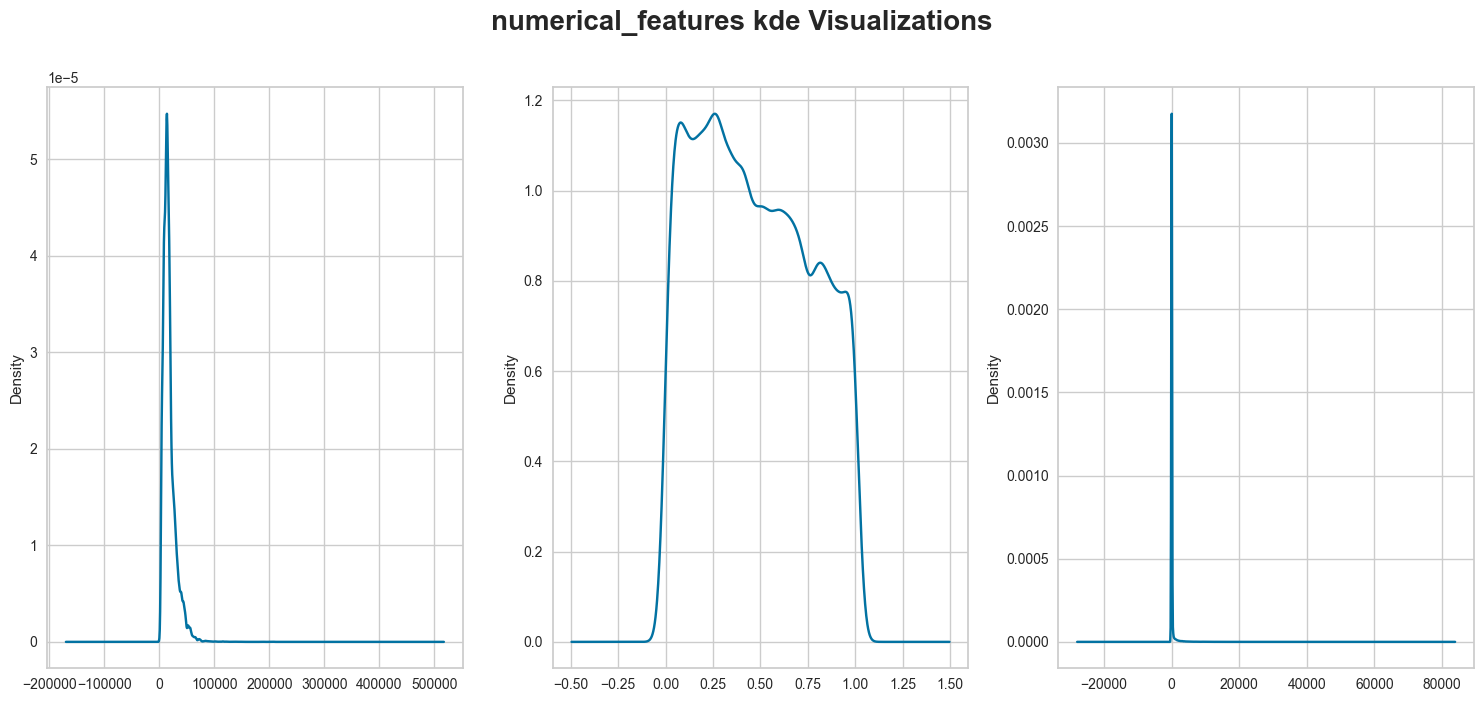

In [9]:
def plot_numerical_features(numerical_features,ChartType):
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}")
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features.png',dpi=500);
        


    plt.tight_layout()
    plt.show()

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde")


---

*Visualizing categorical features :*

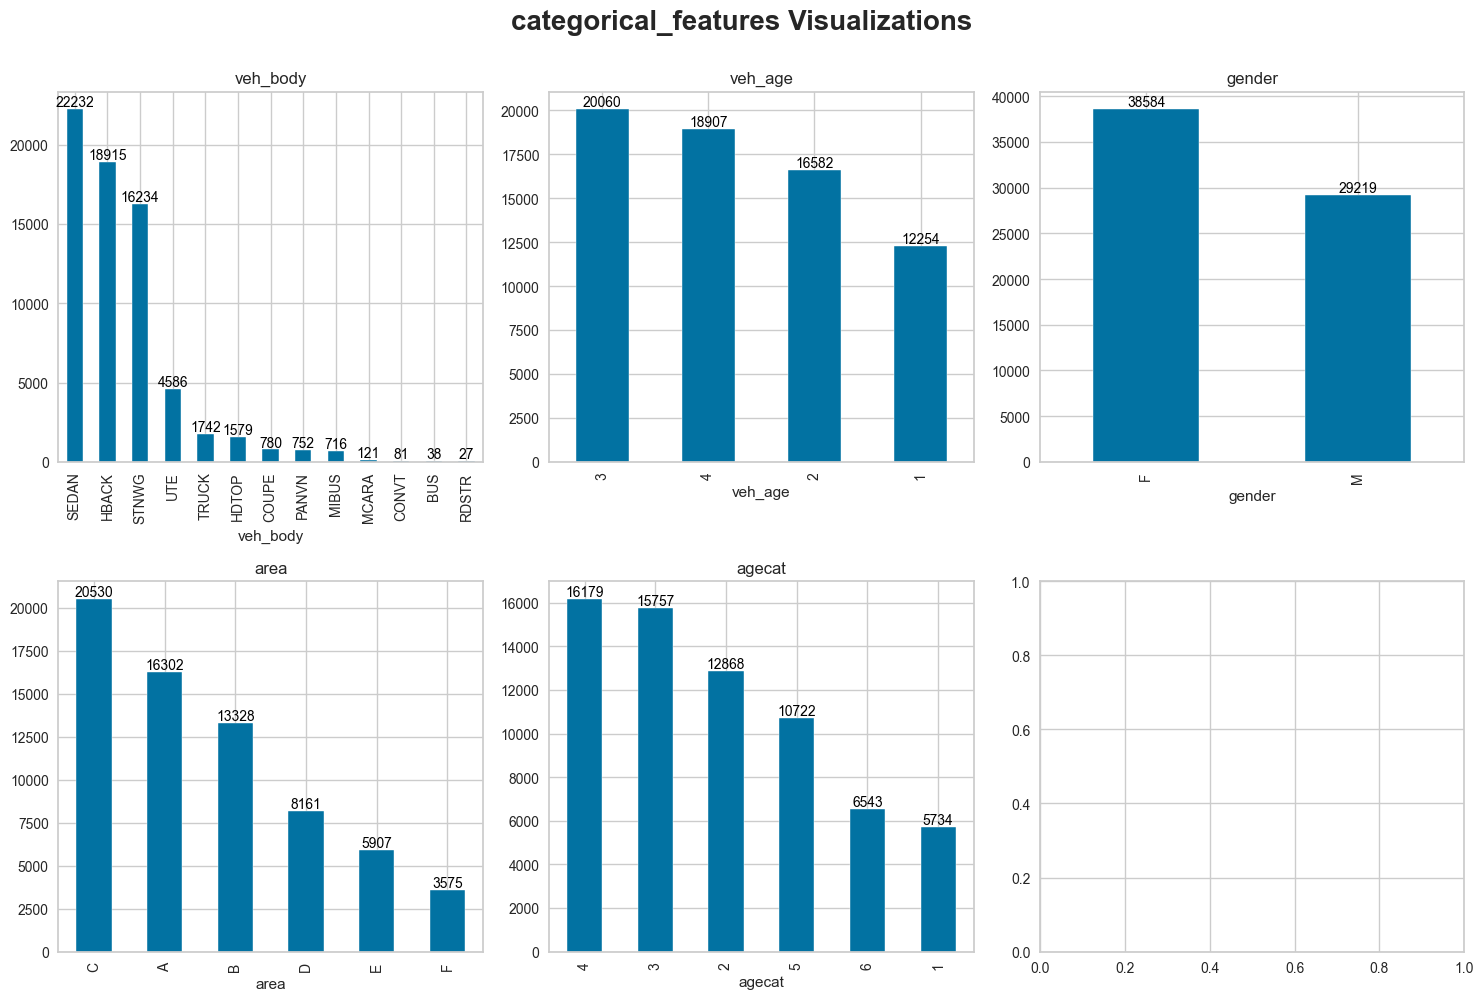

In [10]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [11]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [12]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features Frequency percenatge by area :*

In [13]:
(df.groupby("gender")["area"].value_counts(normalize=True).to_frame()*100).T

gender              F                                                      \
area                C          A          B          D         E        F   
proportion  30.610129  24.055259  19.789021  12.264787  8.475455  4.80535   

gender              M                                                     
area                C          A          B          D        E        F  
proportion  29.849724  24.026974  19.484476  11.737925  9.02338  5.87752

In [14]:
(df.groupby("agecat")["area"].value_counts(normalize=True).to_frame()*100).T

agecat              1                                                      \
area                C          A          B         D         E         F   
proportion  31.228193  24.180042  18.143754  11.49686  8.060014  6.891137   

agecat              2                                  ...          5  \
area                C          A         B          D  ...          B   
proportion  29.584143  23.202487  19.66576  10.664594  ...  20.649133   

agecat                                             6                        \
area                D         E         F          C          A          B   
proportion  12.786794  8.664428  2.891252  29.436039  26.211218  19.303072   

agecat                                     
area                D         E         F  
proportion  14.381782  9.720312  0.947578  

[1 rows x 36 columns]

In [15]:
(df.groupby("veh_age")["area"].value_counts(normalize=True).to_frame()*100).T

veh_age             1                                                       \
area                C          A          B          D         E         F   
proportion  29.597584  24.838789  19.231083  12.325524  8.978859  5.028161   

veh_age             2                                   ...          3  \
area                C          A          B          D  ...          B   
proportion  31.264326  25.045241  20.086862  10.803474  ...  19.072782   

veh_age                                            4                       \
area                D         E         F          C         A          B   
proportion  12.298106  9.127617  5.752742  30.366021  22.75997  20.178779   

veh_age                                    
area                D         E         F  
proportion  12.657357  8.769703  5.268169  

[1 rows x 24 columns]

In [16]:
(df.groupby("veh_body")["area"].value_counts(normalize=True).to_frame()*100).T

veh_body          BUS                                                         \
area                C          F          E          A          B          D   
proportion  28.947368  18.421053  15.789474  13.157895  13.157895  10.526316   

veh_body        CONVT                                  ...      TRUCK  \
area                A          C          B         D  ...          C   
proportion  50.617284  22.222222  18.518519  3.703704  ...  17.623421   

veh_body                                         UTE                        \
area                B         A          F         C          D          E   
proportion  13.662457  12.16992  11.997704  22.45966  18.316616  16.463149   

veh_body                                    
area                B         A          F  
proportion  16.354121  15.43829  10.968164  

[1 rows x 76 columns]

---

*Visualizing Categorical and numerical features by area :*

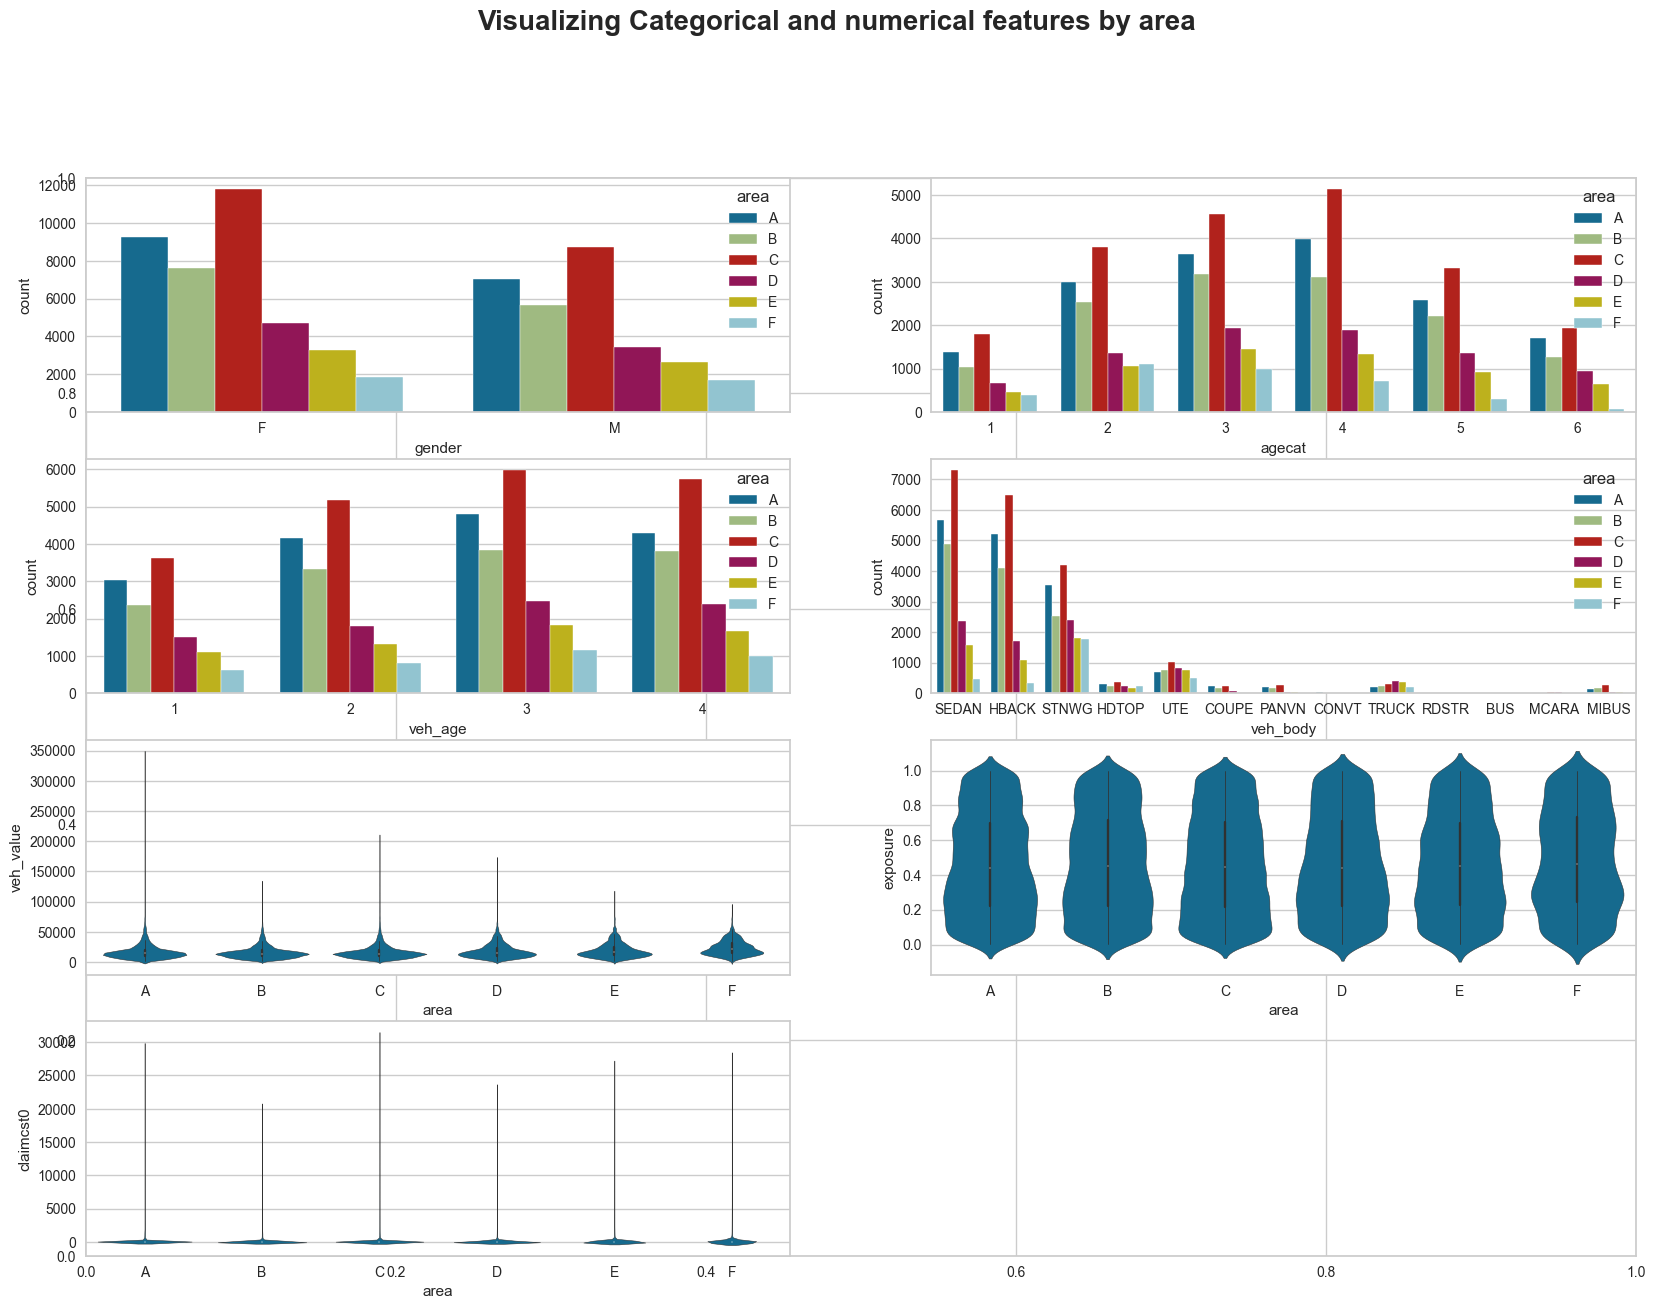

In [17]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by area",fontsize=20,fontweight="bold",y=1.)
plt.subplot(421)
sns.countplot(x="gender",hue="area",data=df)
plt.subplot(422)
sns.countplot(x="agecat",hue="area",data=df)
plt.subplot(423)
sns.countplot(x="veh_age",hue="area",data=df)
plt.subplot(424)
sns.countplot(x="veh_body",hue="area",data=df)
plt.subplot(425)
sns.violinplot(x="area",y="veh_value",data=df)
plt.subplot(426)
sns.violinplot(x="area",y="exposure",data=df)
plt.subplot(427)
sns.violinplot(x="area",y="claimcst0",data=df)
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_area.png',dpi=500);


---

In [18]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [19]:
x=df.drop("area",axis=1)
y=df["area"]

---

*Countinuous features Skewbess -outliers-*

In [20]:
x[countinuous_feature].skew(axis=0,skipna=True)

veh_value     2.974776
exposure      0.175452
claimcst0    13.879256
dtype: float64

---

*Transforming countinuous features to handle the outliers*

In [21]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
x_copy=pt.fit_transform(x[transform_features])

In [22]:
x_copy=pd.DataFrame(x_copy,columns=transform_features)
x_copy

,veh_value,claimcst0
0,0.102057,-0.270112
1,-0.035727,-0.270112
2,0.050345,-0.270112
3,0.081556,-0.270112
4,-0.091772,-0.270112
...,...,...
67790,-0.416781,-0.270112
67791,0.220262,-0.270112
67792,-3.017229,-0.270112
67793,-0.836256,-0.270112


In [23]:
x_copy.skew(axis=0,skipna=True)

veh_value    0.002599
claimcst0    3.432136
dtype: float64

---

*Visualizing  countinuous features after tranformation  :*

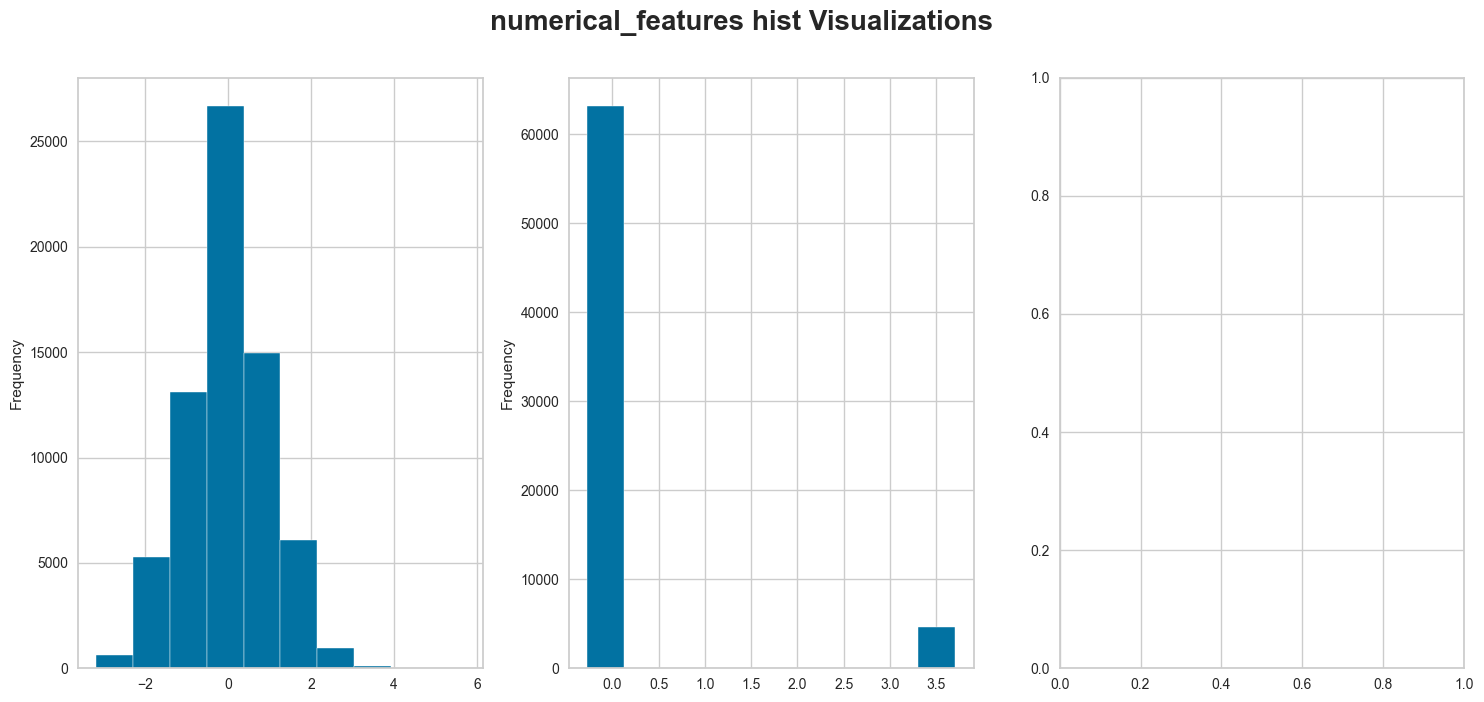

In [24]:
plot_numerical_features(x_copy[["veh_value","claimcst0"]],"hist")

---

In [25]:
for feature in categorical_features:
    print(feature,":",df[feature].unique())

veh_body : [ 9  3 10  4 12  2  7  1 11  8  0  5  6]
veh_age : [0 1 2 3]
gender : [0 1]
area : [0 1 2 3 4 5]
agecat : [0 1 2 3 4 5]


In [26]:
for feature in categorical_features:
    print(feature,":",df[feature].nunique())

veh_body : 13
veh_age : 4
gender : 2
area : 6
agecat : 6


---

*Apply ColumnTransformer to do all transdormation in once :*

In [27]:
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [28]:
sc=StandardScaler()
onencood=OneHotEncoder()
ordinalencod=OrdinalEncoder()
transform_pipe=Pipeline(steps=[
    ("transformer",PowerTransformer(method="yeo-johnson"))
    ])

In [29]:
preprocessor=ColumnTransformer([
    #("OneHotEncoder",onencood,on_columns),
    #("Ordinal_Encoder",ordinalencod,ordered_columns),
    #("transformer",transform_pipe,transform_features),
    ("StandardScaler",sc,x.columns)
]
)

In [30]:
x=preprocessor.fit_transform(x)

---

*Hundling unbalanced data :*

In [31]:
from imblearn.combine import SMOTETomek,SMOTEENN
smt=SMOTEENN(random_state=42,sampling_strategy="minority")
x_re,y_res=smt.fit_resample(x,y)


---

*Split data into train and test subdata :*

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_re,y_res ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (8804, 7) and Y = (8804,) : 
Test data shape of X = (2202, 7) and Y = (2202,) : 


---

*Define models :*

In [33]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "LogisticRegression":LogisticRegression(),
        "SVC":SVC(),
        "KNeighborsClassifier":KNeighborsClassifier()
        
}

---

*Define evaluation funtion :*

In [34]:
def evaluation_preds_list(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
          }
   
    return metrics_dict

In [35]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    return accuracy

---

*Create one function to model the data :*

In [36]:
def evalua_models(x,y,models):
    x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    accuracy_list=[]

    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_accuracy=evaluation_preds(y_test,test_predicted)
       
        accuracy_list.append(test_predicted_accuracy)

        #print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        #print( test_predicted_accuracy)
        #print("===========================")

    report=pd.DataFrame(list(zip(models_list,accuracy_list)),columns=["model","acc"]).sort_values(by="acc",ascending=False) 
    return report
  

---

*Apply Data Modeling*

In [37]:
base_models=evalua_models(x_re,y_res,models)
base_models

,model,acc
2,RandomForestClassifier,0.955495
4,DecisionTreeClassifier,0.935059
7,KNeighborsClassifier,0.926885
1,GradientBoostingClassifier,0.917802
0,XGBRFClassifier,0.915985
6,SVC,0.905086
5,LogisticRegression,0.900091
3,AdaBoostClassifier,0.575386


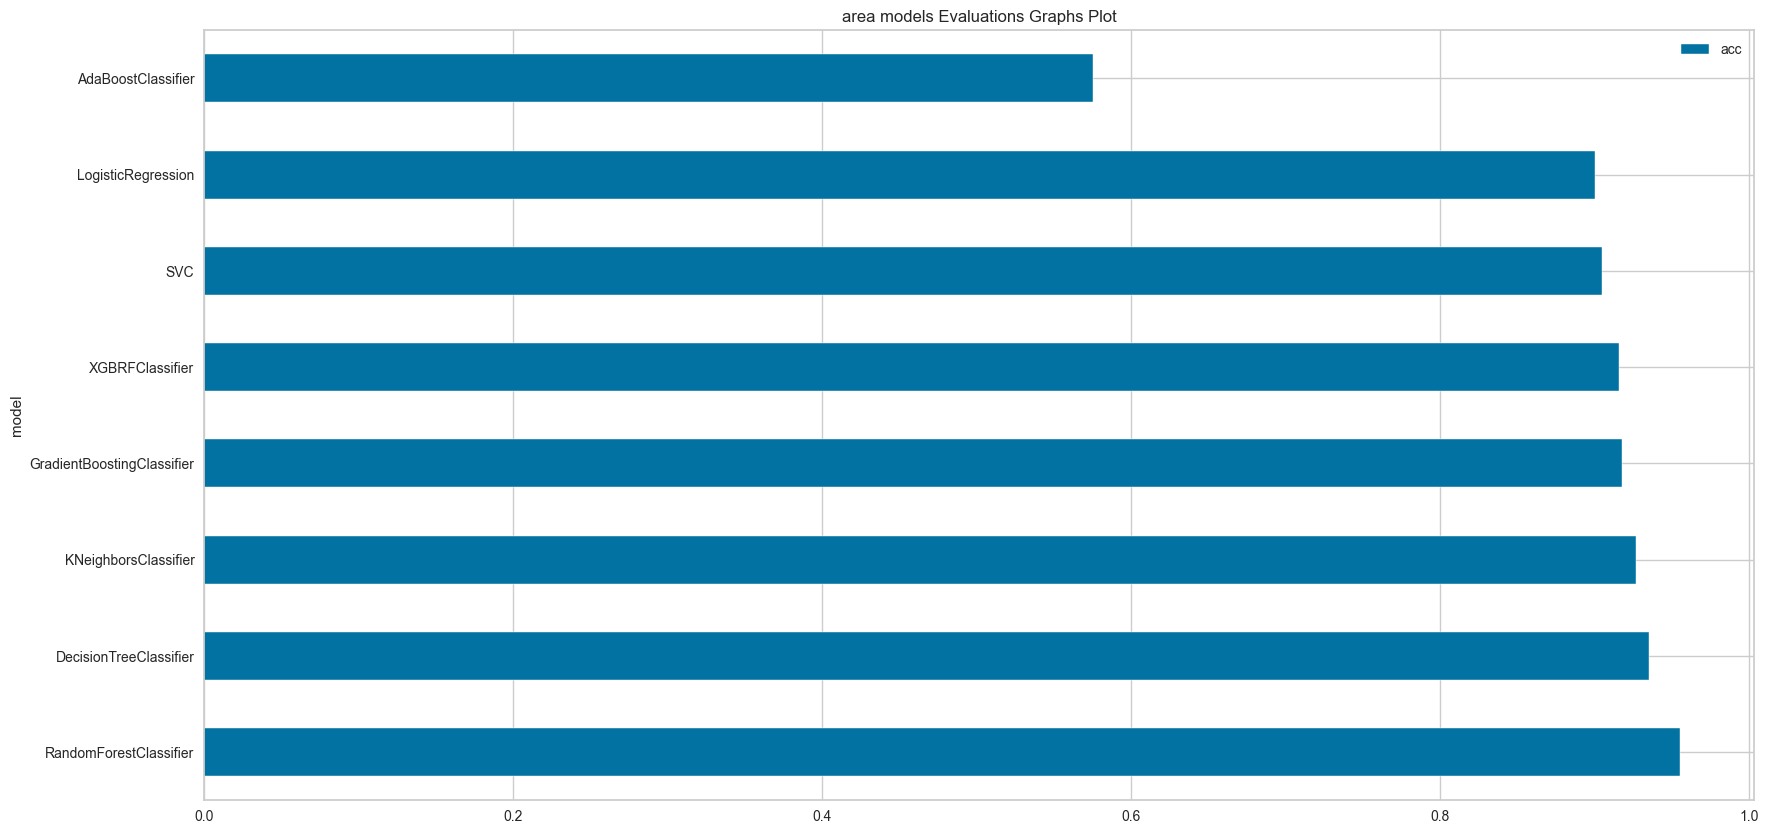

In [38]:
base_models.set_index("model").plot(kind="barh",figsize=(20,10),title="area models Evaluations Graphs Plot");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/area_EvaluationsGraph.png',dpi=500);

---

*Apply RandomForestClassifier :*

In [39]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

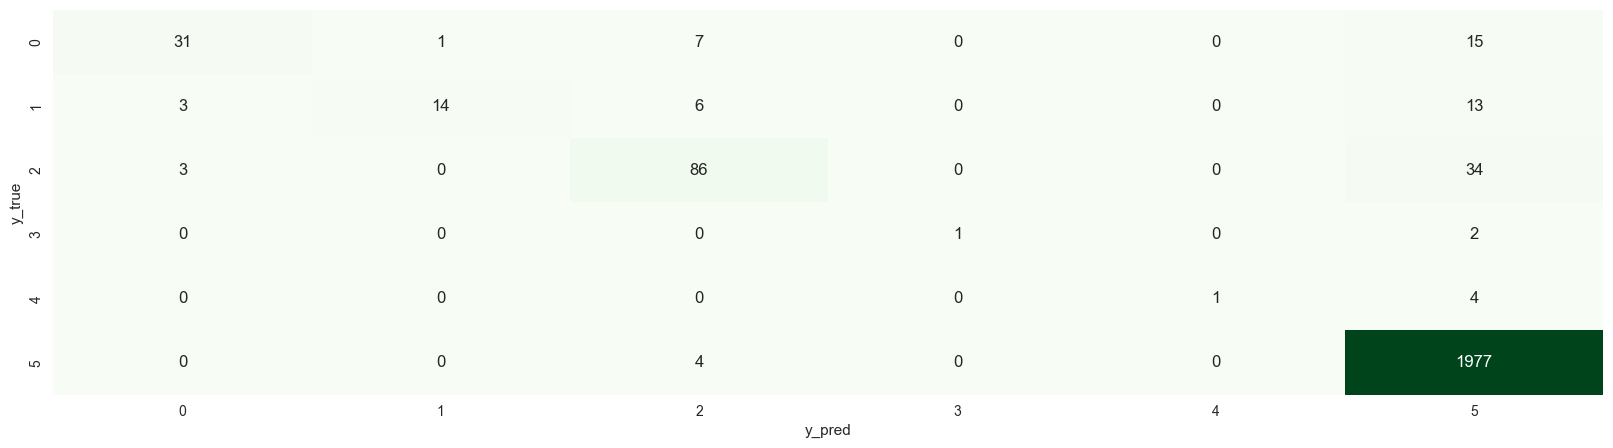

In [40]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Greens", fmt = ".0f",cbar=False)
plt.xlabel("y_pred")
plt.ylabel("y_true");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/area_confusion_matrixPlot.png',dpi=500);

In [41]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.84      0.57      0.68        54
           1       0.93      0.39      0.55        36
           2       0.83      0.70      0.76       123
           3       1.00      0.33      0.50         3
           4       1.00      0.20      0.33         5
           5       0.97      1.00      0.98      1981

    accuracy                           0.96      2202
   macro avg       0.93      0.53      0.63      2202
weighted avg       0.96      0.96      0.95      2202



---

In [42]:
clf.feature_importances_.sum()

1.0

In [43]:
clf.feature_names_in=list(df.drop("area",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.283690
1,exposure,0.240630
2,claimcst0,0.022710
3,veh_body,0.194752
4,veh_age,0.069963
5,gender,0.031496
6,agecat,0.156760


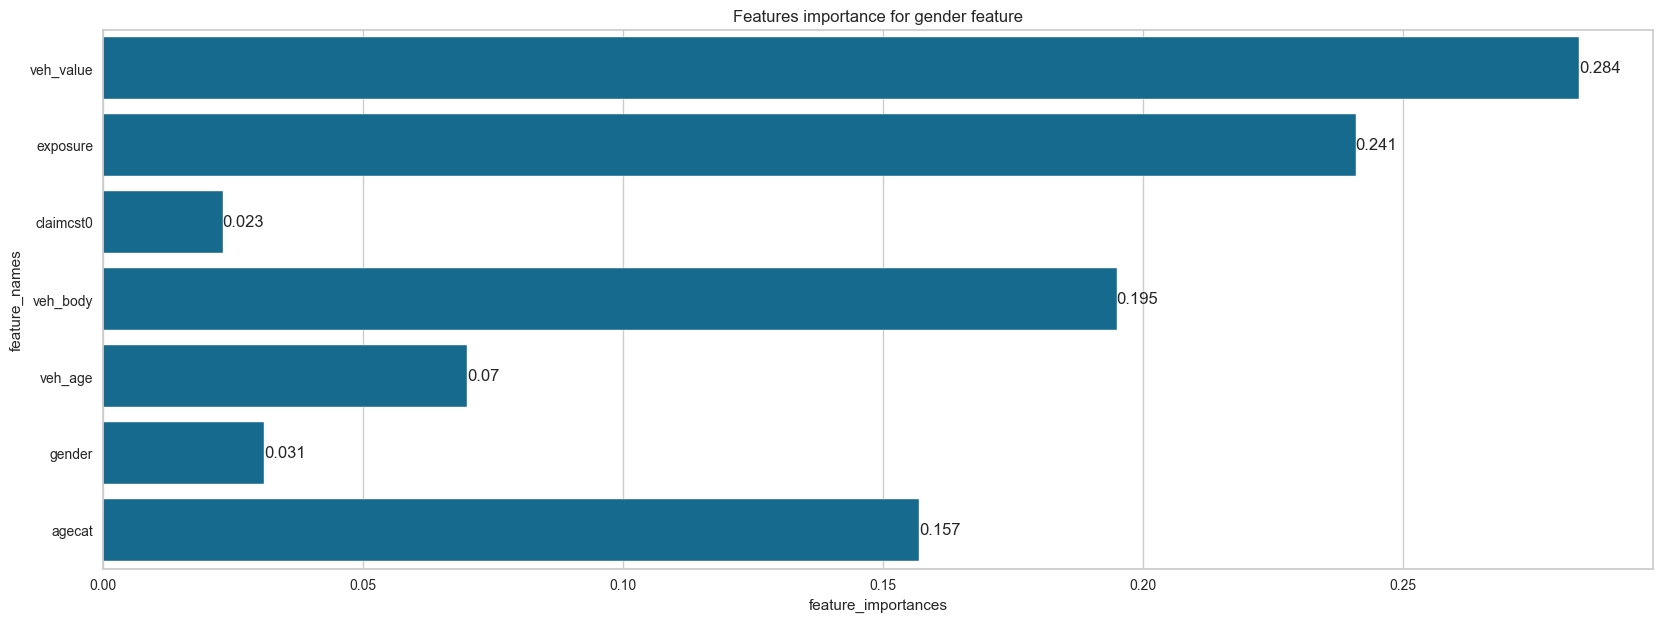

In [44]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for gender feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/area_featureImportanc.png',dpi=500);

*Saving Best model :*

In [45]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/area_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---